# BuildingPit Element

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timml

## Parameters
Define some parameters 

In [2]:
kh = 2.0  # m/day
f_ani = 0.05  # anisotropy factor
kv = f_ani * kh
ctop = 800.0  # resistance top leaky layer in days

In [3]:
ztop = 0.0  # surface elevation
z_well = -13.0  # end depth of the wellscreen
z_dw = -15.0  # bottom elevation of sheetpile wall
z_extra = z_dw - 15.0  # extra layer
zbot = -60.0  # bottom elevation of the model

In [4]:
l = 40.0  # length building pit in m
b = 30.0  # width building pit in m

h_bem = -6.21  # m
offset = 5.0  # distance groundwater extraction element from sheetpiles in m

In [5]:
xy = [
    (-l / 2, -b / 2),
    (l / 2, -b / 2),
    (l / 2, b / 2),
    (-l / 2, b / 2),
    (-l / 2, -b / 2),
]

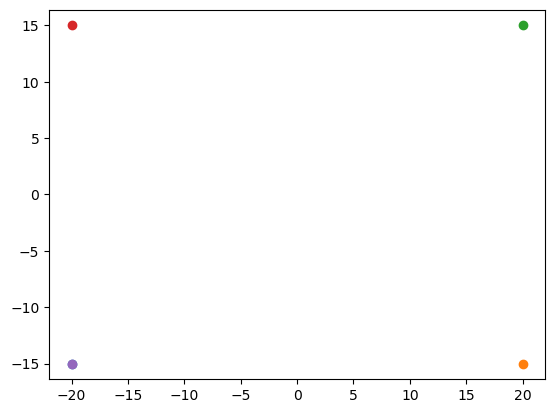

In [6]:
for x, y in xy:
    (p2,) = plt.plot(x, y, "o", label="building pit pts")
plt.axis("equal")
plt.show()

## Model
Set up a model

In [7]:
z = np.array([ztop + 1, ztop, z_dw, z_dw, z_extra, z_extra, zbot])
dz = z[1::2] - z[2::2]
dz

array([15., 15., 30.])

In [8]:
kh_arr = kh * np.ones(dz.shape)

In [9]:
c = np.r_[np.array([ctop]), dz[:-1] / (2 * kv) + dz[1:] / (2 * kv)]
c

array([800., 150., 225.])

Build model, solve, and calculate total discharge and distance to the 5 cm drawdown contour.

In [10]:
ml = timml.ModelMaq(kaq=kh_arr, z=z, c=c, topboundary="semi", hstar=0.0)

layers = np.arange(np.sum(z_dw <= ml.aq.zaqbot))
last_lay_dw = layers[-1]

inhom = timml.BuildingPit(
    ml,
    xy,
    kaq=kh_arr,
    z=z[1:],
    topboundary="conf",
    c=c[1:],
    order=4,
    ndeg=3,
    layers=layers,
)

timml.HeadLineSink(
    ml,
    x1=-l / 2 + offset,
    y1=b / 2 - offset,
    x2=l / 2 - offset,
    y2=b / 2 - offset,
    hls=h_bem,
    layers=np.arange(last_lay_dw + 1),
)
timml.HeadLineSink(
    ml,
    x1=-l / 2 + offset,
    y1=0,
    x2=l / 2 - offset,
    y2=0,
    hls=h_bem,
    layers=np.arange(last_lay_dw + 1),
)
timml.HeadLineSink(
    ml,
    x1=-l / 2 + offset,
    y1=-b / 2 + offset,
    x2=l / 2 - offset,
    y2=-b / 2 + offset,
    hls=h_bem,
    layers=np.arange(last_lay_dw + 1),
)

# ml.solve_mp(nproc=2)
ml.solve()

Qtot = 0.0

for e in ml.elementlist:
    if e.name == "HeadLineSink":
        Qtot += e.discharge()

print("\nDischarge =", np.round(Qtot.sum(), 2), "m^3/dag")

y = np.linspace(-b / 2 - 25, b / 2 + 1100, 201)
hl = ml.headalongline(np.zeros(201), y, layers=[0])
y_5cm = np.interp(
    -0.05, ml.headalongline(np.zeros(201), y, layers=0).squeeze(), y, right=np.nan
)
print("Distance to 5 cm drawdown contour =", np.round(y_5cm, 2), "m")

Number of elements, Number of equations: 21 , 124
.....................
solution complete

Discharge = 47.5 m^3/dag
Distance to 5 cm drawdown contour = 180.0 m


Plot an overview of the model

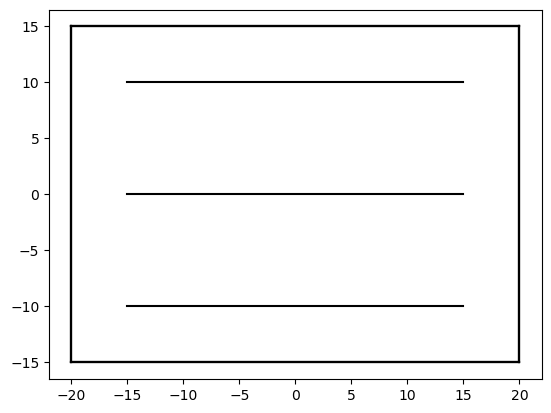

In [11]:
ml.plot()

Visualizations


In [12]:
x = np.linspace(-l / 2 - 25, l / 2 + 1100, 201)
hl = ml.headalongline(x, np.zeros(201), layers=[last_lay_dw, last_lay_dw + 1])

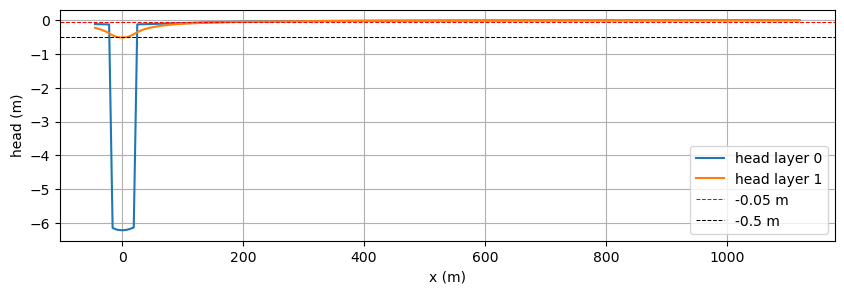

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ax.plot(x, hl[0].squeeze(), label="head layer {}".format(last_lay_dw))
ax.plot(x, hl[1].squeeze(), label="head layer {}".format(last_lay_dw + 1))
ax.axhline(-0.05, color="r", linestyle="dashed", lw=0.75, label="-0.05 m")
ax.axhline(-0.5, color="k", linestyle="dashed", lw=0.75, label="-0.5 m")
ax.set_xlabel("x (m)")
ax.set_ylabel("head (m)")
ax.legend(loc="best")
ax.grid(True)

In [14]:
x = np.linspace(-l / 2 - 25, l / 2 + 1, 201)
hl = ml.headalongline(x, np.zeros(201), layers=[last_lay_dw, last_lay_dw + 1])

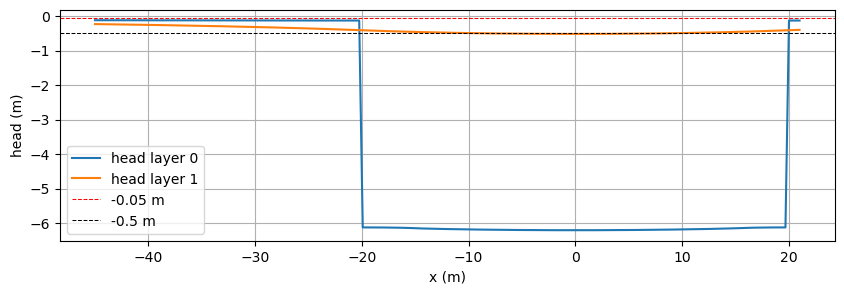

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ax.plot(x, hl[0].squeeze(), label="head layer {}".format(last_lay_dw))
ax.plot(x, hl[1].squeeze(), label="head layer {}".format(last_lay_dw + 1))
ax.axhline(-0.05, color="r", linestyle="dashed", lw=0.75, label="-0.05 m")
ax.axhline(-0.5, color="k", linestyle="dashed", lw=0.75, label="-0.5 m")
ax.set_xlabel("x (m)")
ax.set_ylabel("head (m)")
ax.legend(loc="best")
ax.grid(True)

In [16]:
xoffset = 50
zoffset = 15
x1, x2, y1, y2 = [-l / 2 - xoffset, -l / 2 + xoffset, 0, 0]
nudge = 1e-6
n = 301

In [17]:
x = np.linspace(-l / 2 - 25, l / 2 + 1, 201)

In [18]:
# plot head contour cross-sections
h = ml.headalongline(
    np.linspace(x1 + nudge, x2 - nudge, n), np.linspace(y1 + nudge, y2 - nudge, n)
)
L = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
xg = np.linspace(0, L, n) + x1

zg = 0.5 * (ml.aq.zaqbot + ml.aq.zaqtop)
zg = np.hstack((ml.aq.zaqtop[0], zg, ml.aq.zaqbot[-1]))
h = np.vstack((h[0], h, h[-1]))

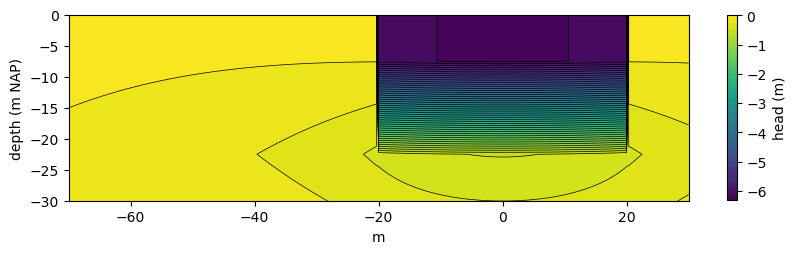

In [19]:
levels = np.linspace(h_bem - 0.1, -0.0, 51)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_aspect("equal")
ml.plot(win=[x1, x2, y1, y2], orientation="ver", newfig=False)
cf = ax.contourf(xg, zg, h, levels)
cs = ax.contour(xg, zg, h, levels, colors="k", linewidths=0.5)
ax.set_ylim(z_dw - zoffset, z_dw + zoffset)
ax.set_ylabel("depth (m NAP)")
ax.set_xlabel("m")

cb = plt.colorbar(cf, ax=ax, shrink=0.4)
cb.set_label("head (m)")
cb.set_ticks(np.arange(-6, 0.1, 1))

## Model 2: Add more layers
Add more layers to the model to get a more accurate solution of the flow towards the building pit.

In [20]:
n = 11  # number of layers around bottom of sheetpile wall

In [21]:
dz_i_top = (z_well - z_dw) / np.sum(np.arange(n + 1))
dz_i_bot = (z_dw - z_extra) / np.sum(np.arange(2 * n + 1))

In [22]:
z_layers_top = np.cumsum(np.arange(n) * dz_i_top)
z_layers_bot = np.cumsum(np.arange(2 * n) * dz_i_bot)

In [23]:
zgr = np.r_[z_dw + z_layers_top[::-1], (z_dw - z_layers_bot)[1:]]

In [24]:
z4 = np.r_[
    np.array([ztop + 1, ztop, z_well, z_well]),
    np.repeat(zgr, 2, 0),
    z_extra,
    z_extra,
    zbot,
]

In [25]:
dz4 = z4[1:-1:2] - z4[2::2]

In [26]:
kh_arr = kh * np.ones(dz4.shape)

In [27]:
c = np.r_[np.array([ctop]), dz4[:-1] / (2 * kv) + dz4[1:] / (2 * kv)]

In [28]:
kh_arr2 = kh_arr.copy()
kh_arr2[0] = 1e-5

Build model, solve, and calculate total discharge and distance to the 5 cm drawdown contour.

In [29]:
ml = timml.ModelMaq(kaq=kh_arr, z=z4, c=c, topboundary="semi", hstar=0.0)

layers = np.arange(np.sum(z_dw <= ml.aq.zaqbot))
last_lay_dw = layers[-1]
inhom = timml.BuildingPit(
    ml,
    xy,
    kaq=kh_arr2,
    z=z4[1:],
    topboundary="conf",
    c=c[1:],
    order=4,
    ndeg=3,
    layers=layers,
)

wlayers = np.arange(np.sum(-14 <= ml.aq.zaqbot))
wlayers = wlayers[1:]

timml.HeadLineSink(
    ml,
    x1=-l / 2 + offset,
    y1=b / 2 - offset,
    x2=l / 2 - offset,
    y2=b / 2 - offset,
    hls=h_bem,
    layers=wlayers,
)
timml.HeadLineSink(
    ml,
    x1=-l / 2 + offset,
    y1=0,
    x2=l / 2 - offset,
    y2=0,
    hls=h_bem,
    layers=wlayers,
    order=5,
)
timml.HeadLineSink(
    ml,
    x1=-l / 2 + offset,
    y1=-b / 2 + offset,
    x2=l / 2 - offset,
    y2=-b / 2 + offset,
    hls=h_bem,
    layers=wlayers,
)

# ml.solve_mp(nproc=2)
ml.solve()

Qtot = 0.0

for e in ml.elementlist:
    if e.name == "HeadLineSink":
        Qtot += e.discharge()

print("\nDischarge =", np.round(Qtot.sum(), 2), "m^3/dag")

y = np.linspace(-b / 2 - 25, b / 2 + 1100, 201)
hl = ml.headalongline(np.zeros(201), y, layers=[0])
y_5cm = np.interp(
    -0.05, ml.headalongline(np.zeros(201), y, layers=0).squeeze(), y, right=np.nan
)
print("Distance to 5 cm drawdown contour =", np.round(y_5cm, 2), "m")

Number of elements, Number of equations: 21 , 1425
.....................
solution complete

Discharge = 147.78 m^3/dag
Distance to 5 cm drawdown contour = 404.42 m


In [30]:
last_lay_dw = layers[-1]

In [31]:
x = np.linspace(-l / 2 - 25, l / 2 + 1100, 201)
hl = ml.headalongline(x, np.zeros(201), layers=[0, last_lay_dw, last_lay_dw + 1])

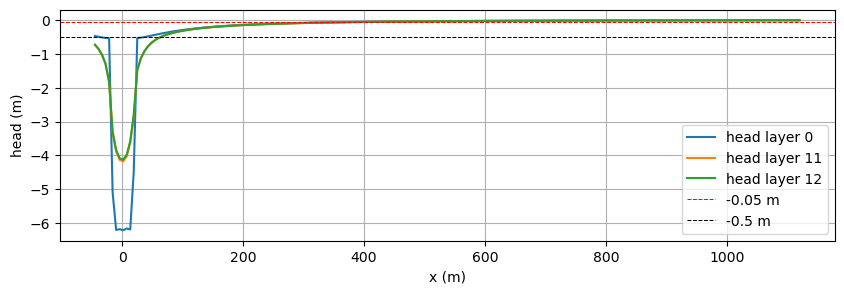

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ax.plot(x, hl[0].squeeze(), label="head layer 0")
ax.plot(x, hl[1].squeeze(), label="head layer {}".format(last_lay_dw))
ax.plot(x, hl[2].squeeze(), label="head layer {}".format(last_lay_dw + 1))
ax.axhline(-0.05, color="r", linestyle="dashed", lw=0.75, label="-0.05 m")
ax.axhline(-0.5, color="k", linestyle="dashed", lw=0.75, label="-0.5 m")
ax.set_xlabel("x (m)")
ax.set_ylabel("head (m)")
ax.legend(loc="best")
ax.grid(True)

In [33]:
x = np.linspace(-l / 2 - 25, l / 2 + 1, 201)
hl = ml.headalongline(x, np.zeros(201), layers=[0, last_lay_dw, last_lay_dw + 1])

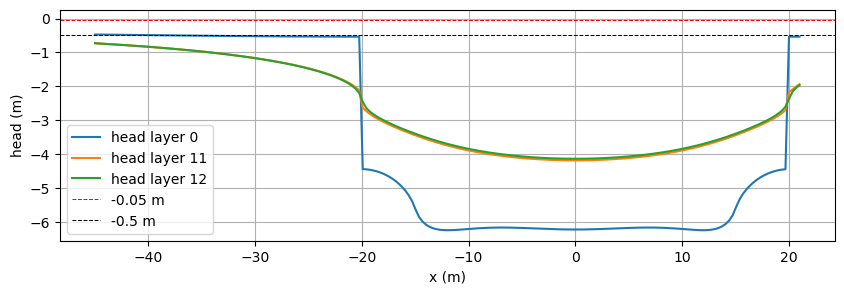

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ax.plot(x, hl[0].squeeze(), label="head layer 0")
ax.plot(x, hl[1].squeeze(), label="head layer {}".format(last_lay_dw))
ax.plot(x, hl[2].squeeze(), label="head layer {}".format(last_lay_dw + 1))
ax.axhline(-0.05, color="r", linestyle="dashed", lw=0.75, label="-0.05 m")
ax.axhline(-0.5, color="k", linestyle="dashed", lw=0.75, label="-0.5 m")
ax.set_xlabel("x (m)")
ax.set_ylabel("head (m)")
ax.legend(loc="best")
ax.grid(True)

In [35]:
xoffset = 50
zoffset = 15
x1, x2, y1, y2 = [-l / 2 - xoffset, -l / 2 + xoffset, 0, 0]
nudge = 1e-6
n = 301

In [36]:
# plot head contour cross-sections
h = ml.headalongline(
    np.linspace(x1 + nudge, x2 - nudge, n), np.linspace(y1 + nudge, y2 - nudge, n)
)
L = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
xg = np.linspace(0, L, n) + x1

zg = 0.5 * (ml.aq.zaqbot + ml.aq.zaqtop)
zg = np.hstack((ml.aq.zaqtop[0], zg, ml.aq.zaqbot[-1]))
h = np.vstack((h[0], h, h[-1]))

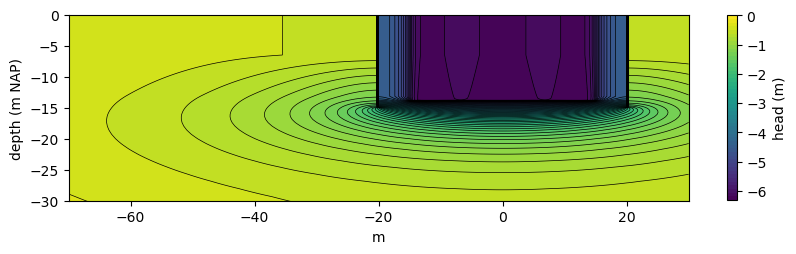

In [37]:
levels = np.linspace(h_bem - 0.1, -0.0, 51)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_aspect("equal")
ml.plot(win=[x1, x2, y1, y2], orientation="ver", newfig=False)
cf = ax.contourf(xg, zg, h, levels)
cs = ax.contour(xg, zg, h, levels, colors="k", linewidths=0.5)
ax.set_ylim(z_dw - zoffset, z_dw + zoffset)
ax.set_ylabel("depth (m NAP)")
ax.set_xlabel("m")

cb = plt.colorbar(cf, ax=ax, shrink=0.4)
cb.ax.set_ylabel("head (m)")
cb.set_ticks(np.arange(-6, 0.1, 1))